In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
# 为了正常显示中文

mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 12  # 字体大小
plt.rc('axes', unicode_minus=False)


In [2]:
# 加载数据集
boston = load_boston()
# 获取特征值和目标值
X, y = boston.data, boston.target
# 获取特征名称
feature_name = boston.feature_names
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\Users\fesia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [3]:
data_whole = np.concatenate([boston['data'], np.expand_dims(boston['target'], axis=1)], axis=-1)
data_whole = pd.DataFrame.from_dict(data_whole)

In [4]:
data_whole
# last column is the target 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [5]:
params = {'n_estimators': 500, # 弱分类器的个数
          'max_depth': 5,       # 弱分类器（CART回归树）的最大深度
          'min_samples_split': 5, # 分裂内部节点所需的最小样本数
          'learning_rate': 0.05,  # 学习率
          'loss': 'ls'}           # 损失函数：均方误差损失函数
GBDTreg = GradientBoostingRegressor(**params)
GBDTreg.fit(X_train, y_train)

C:\Users\fesia\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(learning_rate=0.05, loss='ls', max_depth=5,
                          min_samples_split=5, n_estimators=500)

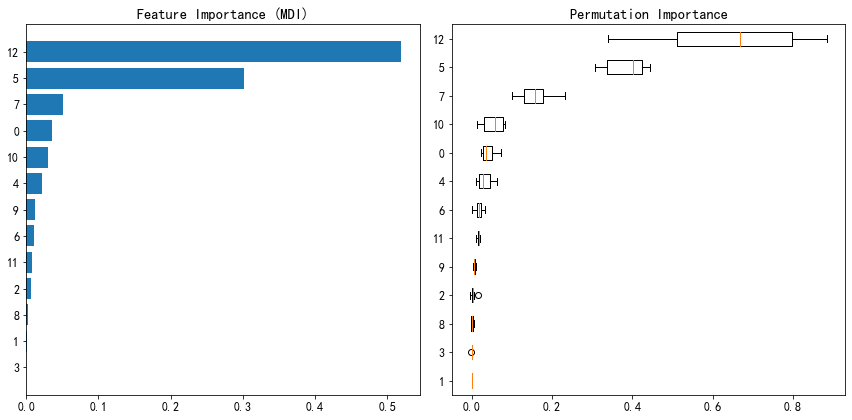

In [6]:
# feature importance from tree splitted gains
feature_importance = GBDTreg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(data_whole.keys())[sorted_idx])
plt.title('Feature Importance (MDI)')

# feature importance from feature permutation
result = permutation_importance(GBDTreg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(data_whole.keys())[sorted_idx])
plt.title("Permutation Importance")
fig.tight_layout()
plt.show()

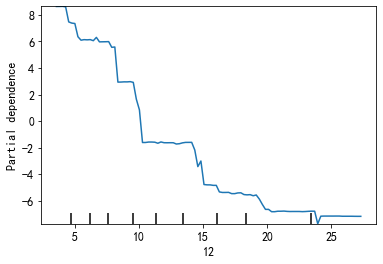

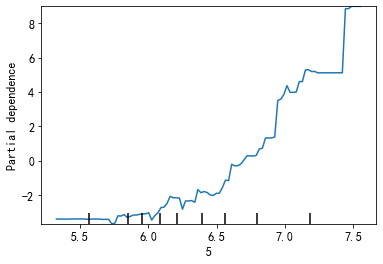

In [7]:
# draw 12th and 5th feature PDP, which are most important features
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [12])
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [5])

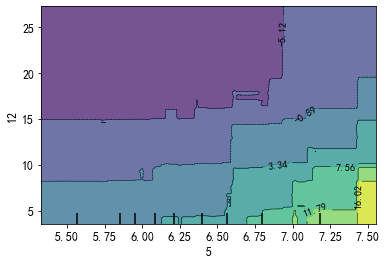

In [8]:
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [(5, 12)])

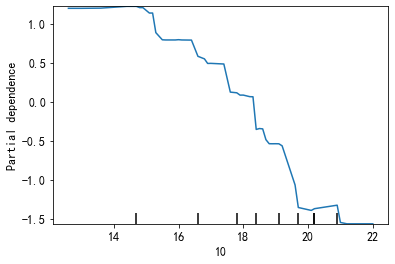

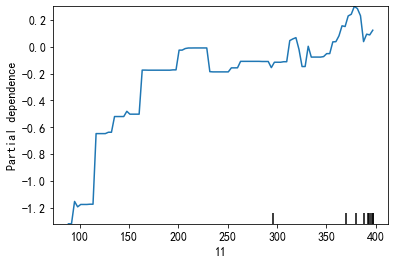

In [9]:
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [10])
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [11])

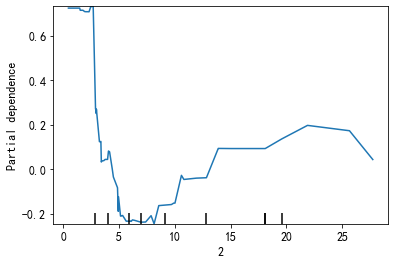

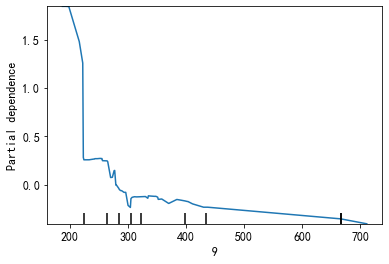

In [10]:
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [2])
PartialDependenceDisplay.from_estimator(GBDTreg, X_train, [9])

In [77]:
def draw_marginal_plot(data, feat_axis, num_parts):
    max_v = np.max(data[:, feat_axis])
    min_v = np.min(data[:, feat_axis])
    step = (max_v - min_v) / num_parts
    df = pd.DataFrame(data)
    data_record = []
    for each_part in range(num_parts):
        low_bound = min_v + each_part * step
        upper_bound = min_v + (each_part + 1) * step
        data_select = df[(df[feat_axis] > low_bound) & (df[feat_axis] < upper_bound)]
        if len(data_select) > 0:
            data_pred = GBDTreg.predict(data_select)
            data_mean = np.array(data_pred).mean()
            data_std = np.std(np.array(data_pred))
            data_record.append((each_part, data_mean, data_std))
    return data_record, step

Text(0.5, 1.0, 'Marginal Plot')

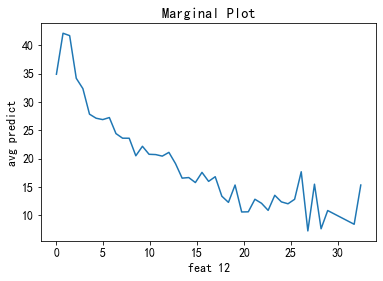

In [78]:
feat_id = 12
data_record, step = draw_marginal_plot(X_train, feat_id, 50)
data_record = np.array(data_record)
plt.plot(data_record[:, 0] * step, data_record[:, 1])
plt.xlabel("feat {}".format(feat_id))
plt.ylabel("avg predict")
plt.title("Marginal Plot")

Text(0.5, 1.0, 'Marginal Plot')

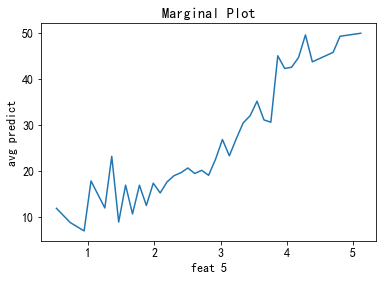

In [79]:
feat_id = 5
data_record, step = draw_marginal_plot(X_train, feat_id, 50)
data_record = np.array(data_record)
plt.plot(data_record[:, 0] * step, data_record[:, 1])
plt.xlabel("feat {}".format(feat_id))
plt.ylabel("avg predict")
plt.title("Marginal Plot")

Text(0.5, 1.0, 'Marginal Plot')

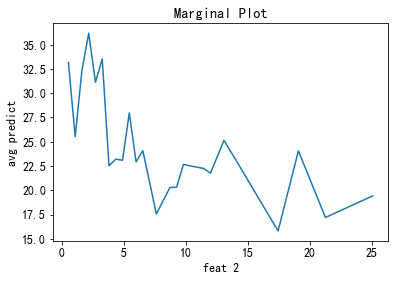

In [80]:
feat_id = 2
data_record, step = draw_marginal_plot(X_train, feat_id, 50)
data_record = np.array(data_record)
plt.plot(data_record[:, 0] * step, data_record[:, 1])
plt.xlabel("feat {}".format(feat_id))
plt.ylabel("avg predict")
plt.title("Marginal Plot")

Text(0.5, 1.0, 'Marginal Plot')

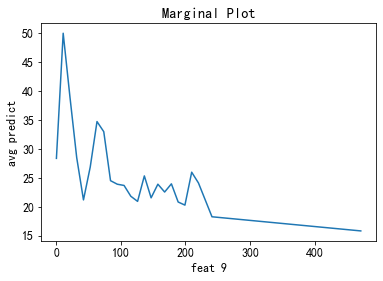

In [82]:
feat_id = 9
data_record, step = draw_marginal_plot(X_train, feat_id, 50)
data_record = np.array(data_record)
plt.plot(data_record[:, 0] * step, data_record[:, 1])
plt.xlabel("feat {}".format(feat_id))
plt.ylabel("avg predict")
plt.title("Marginal Plot")

(array([ 2.,  1.,  6.,  5.,  3.,  6.,  6.,  9.,  8., 18., 14., 11., 11.,
        11., 19., 24., 22., 23., 24., 28., 20., 21., 11.,  6.,  7.,  5.,
         7.,  7.,  6.,  6.,  4.,  7.,  3.,  7.,  6.,  3.,  2.,  0.,  1.,
         0.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  0.,  2., 12.]),
 array([ 4.99991762,  5.90139988,  6.80288214,  7.7043644 ,  8.60584666,
         9.50732892, 10.40881118, 11.31029344, 12.2117757 , 13.11325796,
        14.01474022, 14.91622248, 15.81770474, 16.719187  , 17.62066926,
        18.52215152, 19.42363378, 20.32511603, 21.22659829, 22.12808055,
        23.02956281, 23.93104507, 24.83252733, 25.73400959, 26.63549185,
        27.53697411, 28.43845637, 29.33993863, 30.24142089, 31.14290315,
        32.04438541, 32.94586767, 33.84734993, 34.74883219, 35.65031445,
        36.55179671, 37.45327897, 38.35476123, 39.25624349, 40.15772575,
        41.05920801, 41.96069027, 42.86217253, 43.76365479, 44.66513705,
        45.56661931, 46.46810157, 47.36958383, 48.27106609,

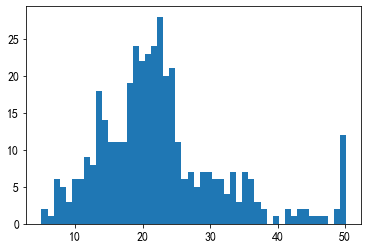

In [87]:
data = GBDTreg.predict(X_train)
plt.hist(data, bins=50)